<a href="https://colab.research.google.com/github/raudh1/LorenzModel/blob/main/generate_trajectories/GenerateTrajLorenzRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GENERATE TRAJ

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from random import randint
import os
import sys
import string
#from torch import Dataset, Dataloader
from numpy import linalg as LA
from sklearn.model_selection import train_test_split

In [5]:
import numpy as np
from generate import *


device= cpu


In [3]:
from matplotlib import pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Set files and directories

In [23]:
#DEFINE RNN

class Sequence(nn.Module):
    def __init__(self, hidden, layer, features, dropout):
        super(Sequence, self).__init__()
        self.hidden   = hidden
        self.layer    = layer
        self.features = features
        self.h_0 =torch.normal(mean=0.0, std=torch.ones(layer,1, hidden, dtype=torch.double)).to(device)

        self.rnn  = nn.RNN(self.features, self.hidden, self.layer, dropout=dropout)
        self.linear = nn.Linear(self.hidden, self.features)
 
    def forward(self, input, h_t=None):
        if h_t is None:
          h_t=self.h_0
        self.rnn.flatten_parameters()
        out, h_t = self.rnn(input, h_t)
        output = out.view(input.size(0)*input.size(1),self.hidden)
        output = self.linear(output)
        output = output.view(input.size(0),input.size(1),self.features)
        return output , h_t


    def predict(self, init_points,N=100, h_t=None):
        if h_t is None:
          h_t=self.h_0
        
        init_pred, h_t = self.forward(init_points, h_t)
        output=torch.zeros(init_pred.shape[0]+N,1,self.features)
        output[:init_pred.shape[0]]=init_pred
        inp = init_pred[-1].unsqueeze(0)
        
        for i in range(init_pred.shape[0],N+init_pred.shape[0]):

          inp, h_t =self.forward(inp,h_t)
          output[i]=inp

        return output


In [24]:
if __name__ == '__main__':
    np.random.seed(0)
    # load data and make training set
    hidden   = 100
    layer    = 1
    features = 3
    dropout  = 0
    # build the model
    case = 'FULL'
        
    ini = 25


In [29]:
k=0

train_data, valid_data, test_data=load_data(case,2)
print(train_data.shape)


seq = Sequence(hidden,layer,features,dropout).double().to(device)


torch.Size([10125, 1, 3])


In [30]:
train_loss, valid_loss = train(seq,train_data,valid_data,lr=0.04,epoch=500)

input shape= torch.Size([10125, 1, 3])  target shape = torch.Size([1687, 1, 3])
0 train loss 275.3663743165337 valid loss 195.42337749303422
50 train loss 2.4600713517885695 valid loss 2.404727267300931
100 train loss 0.2608253993490526 valid loss 0.41920093751294457
150 train loss 0.10992121750791478 valid loss 0.2994705044473764
200 train loss 0.05939719714520613 valid loss 0.26322800318573125
250 train loss 0.04488757969321988 valid loss 0.25553221738027293
300 train loss 0.027871299723078582 valid loss 0.2413828007091535
350 train loss 0.05114693838271175 valid loss 0.2725163477758366
400 train loss 0.018119898980893147 valid loss 0.2344747701307861
450 train loss 0.031109308071585705 valid loss 0.25542436739612706
last epoch:  500


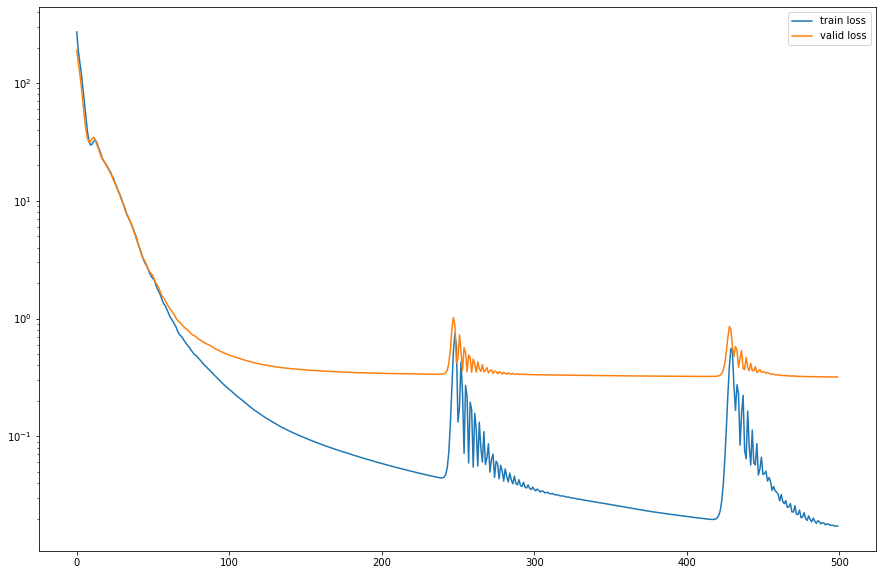

In [12]:
plt.figure(figsize=(15,10))

plt.plot(train_loss,label='train loss')
plt.plot(valid_loss,label='valid loss')
plt.semilogy()
plt.legend()
plt.show()

In [14]:
input=train_data   

   # Chose dataset you want to compare the model with
history=3000
future=1000
# def generate_traj(model,inp,h,f): # h is history and f is future inp is input that can be train or test or validation set
  # traj_1step ,_=  model(inp[:h+f])  # 1 step
  # traj = model.predict(inp[:h],N=f) #generated

  # return traj_1step.detach().numpy(), traj.detach().numpy()

**PLOT FUNCTIONS**

In [ ]:
#def plot_traj(traj_1step,traj,h,coordinate='x',data=False,error=False): # h is history traj is generated traj
  if coordinate=='x':
    i=0
  if coordinate=='y':
    i=1
  if coordinate=='z':
    i=2

  plt.figure(figsize=(14.4,8.8))
  plt.plot(traj_1step[:,0,i],label='1step model')
  plt.plot(traj[:,0,i],label='traj_generate')
  if data is True:
    plt.plot(input[:,0,i],label='real data')
  if error is True:
    print(np.mean(np.power(traj_1step[h:h+future,0,i]-traj[h:h+future,0,i],2)))
  plt.scatter(h,traj_1step[h,0,i],color='red')

  plt.xlim(h-100,len(traj))
  plt.ylabel(rf'${coordinate}(t)$',fontsize=20)
  plt.xlabel(r'$t$',fontsize=20)
  plt.legend()
  plt.show()
  print(traj_1step.shape, traj.shape)
  print(np.linalg.norm(traj_1step-traj))

#def plot_traj_3D(traj,traj_1step,inp,h=1000,f=10,data=False):
  fig = plt.figure(figsize=(20,15))
  ax = fig.gca(projection="3d")
  start=h

  ax.plot(traj_1step[start:start+f,0,0],traj_1step[start:start+f,0,1],traj_1step[start:start+f,0,2],label='1 step traj',linestyle='--')
  ax.plot(traj[start:start+f,0,0],traj[start:start+f,0,1],traj[start:start+f,0,2],label='generated traj')
  
  if data is True:
    ax.plot(inp[start:h+f,0,0],inp[start:h+f,0,1],inp[start:h+f,0,2],label='real traj')

  
  ax.scatter3D(traj_1step[h,0,0],traj_1step[h,0,1],traj_1step[h,0,2],c='green',label='starting point')
  ax.set_xlabel(r'$x$',fontsize=30)
  ax.set_ylabel(r'$y$',fontsize=30)
  ax.set_zlabel(r'$z$',fontsize=30)

  ax.legend(fontsize=15)

In [26]:
traj_1step_last_model, traj_generated_last_model = generate_traj(inp=input,model=seq,h=history,f=future)

0.3891353750535195


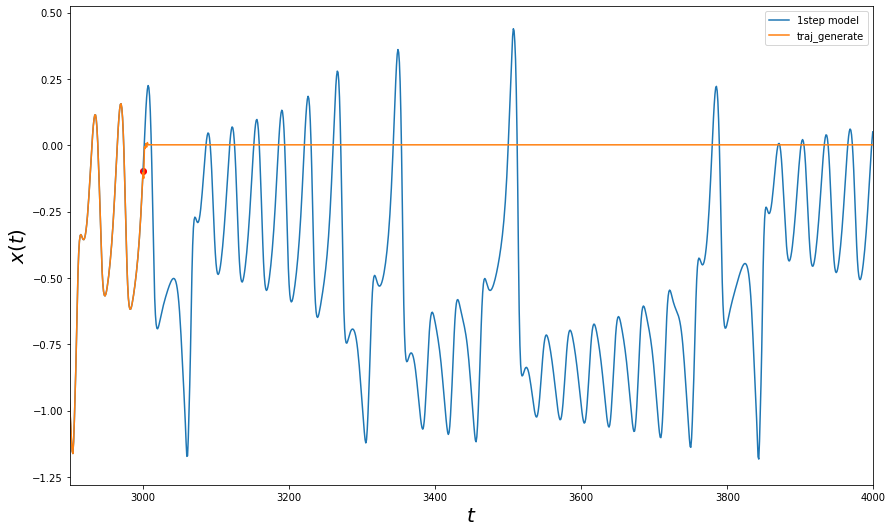

(4000, 1, 3) (4000, 1, 3)
24.318678925619952


In [28]:
plot_traj(traj_1step_last_model,traj_generated_last_model,coordinate='x',data=False,h=history,error=True)

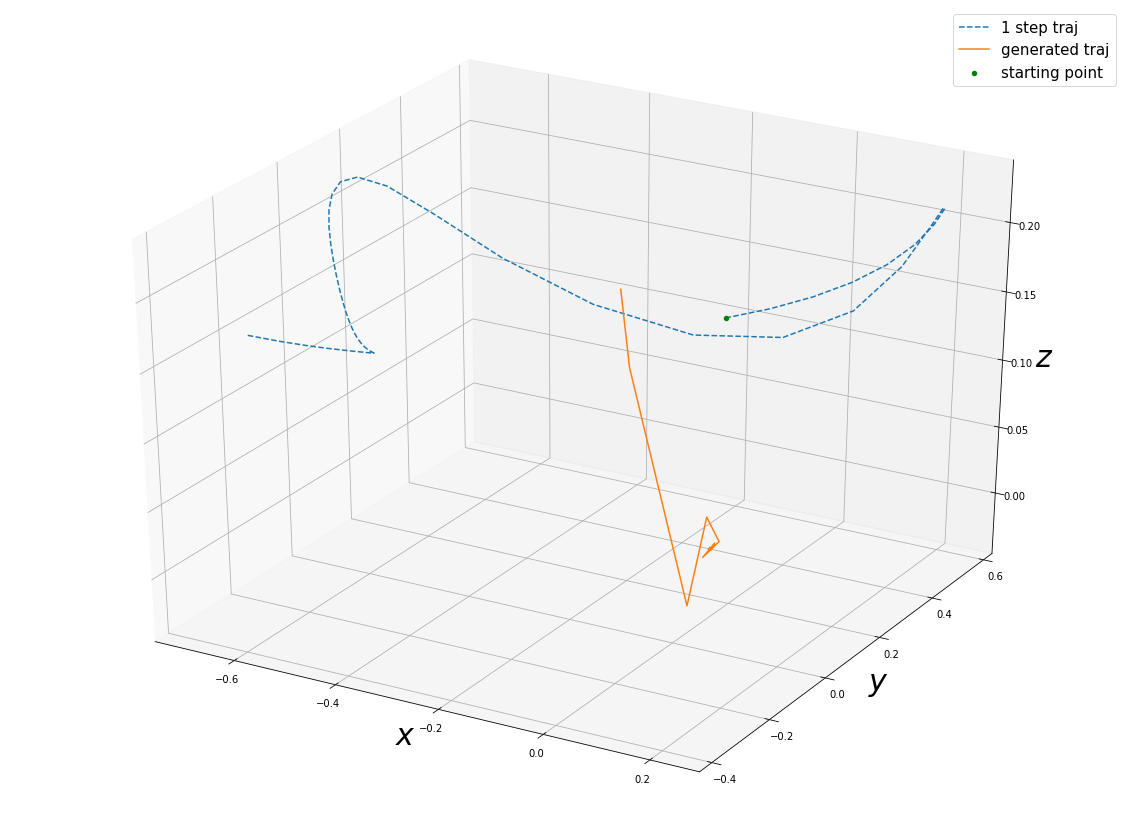

In [27]:
plot_traj_3D(traj_generated_last_model,traj_1step_last_model,inp=train_data,h=history,f=50,data=False) # plot 'future' points after 'history' points

Comparison with best model (min validation loss) 

In [ ]:
bestmdl = Sequence(hidden,layer,features,dropout)
bestmdl.load_state_dict(torch.load('./param'))

best_traj_1step , best_traj=  generate_traj(bestmdl,inp=test_data,h=1000,f=600)

In [ ]:
test_data.shape

torch.Size([1687, 1, 3])

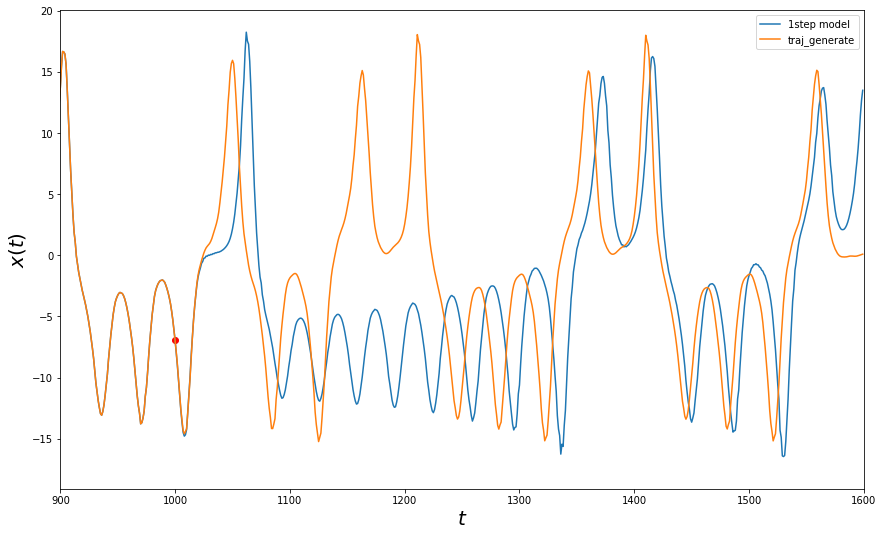

(1600, 1, 3) (1600, 1, 3)
428.5653313547668


In [ ]:
plot_traj(best_traj_1step,best_traj,h=1000)

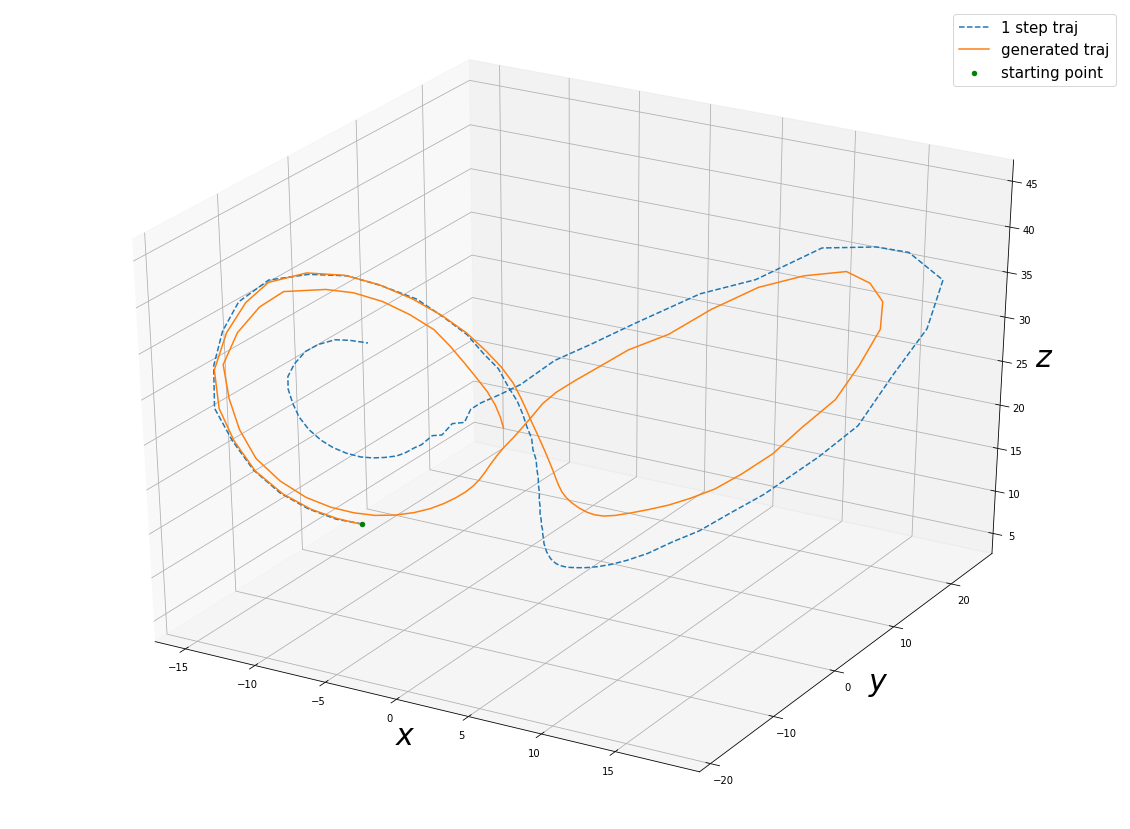

In [ ]:
plot_traj_3D(best_traj,best_traj_1step,h=1000,f=100,inp=test_data)